1. Generate a 16x16 - dim position encoding using an interweaved $sin()$ and $cos()$ functions: $B = \{b_1, b_2, ..., b_{16}\}$ where $b_i \in \mathbb{R}^{16}$. Distribute the domain of 16-dim between $0$ and $2\pi$.

In [705]:
import numpy as np
import matplotlib.pyplot as plt

In [706]:
def get_angles(pos, i, d_model):
    # Compute pos / 10000^(2i / [d_model])
    angle_rates = 1 / np.power(10000, 2 * (i // 2) / np.float32(d_model))
    
    # Distribute domain between 0 and 2pi
    return np.mod(pos * angle_rates, 2 * np.pi)

def pos_enc(pos, d_model):
    angle_rads = get_angles(np.arange(pos)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    
    print(f'required min rad: {0} max rad: {2 * np.pi}')
    print(f'min rad: {np.min(angle_rads)} max rad: {np.max(angle_rads)}')
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) # sin to even indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) # cos to odd indices
    
    pos_enc = angle_rads[np.newaxis, ...]
    
    return pos_enc

In [707]:
tokens = 16
dims = 16

pos_enc_res = pos_enc(tokens, dims)

print(f'Shape of result is {pos_enc_res.shape}')

required min rad: 0 max rad: 6.283185307179586
min rad: 0.0 max rad: 6.0
Shape of result is (1, 16, 16)


2. If $B$ is a set of basis vectors, are the vectors orthogonal? Orthonormal? If not, make the basis vectors orthogonal and orthonormal using Gram-Schmidt method.

In [708]:
def check_orthonormal(mat):
    # A^T * A = I to check for orthogonality
    # Columns of A should be the bases
    check_mat = np.dot(mat.T, mat)
    cols_sum = np.sum(check_mat, axis=0)
    
    # Return (is_orthogonal, is_orthonormal)
    return np.bitwise_and.reduce(cols_sum <= 1 + (1e-8)), check_normal(mat)

def get_basis_with_vector(basis, vec):
    sub_scales = np.dot(basis.T, vec)
    sub_vecs = sub_scales.T * basis
    
    basis_vec = vec[:, 0] - np.sum(sub_vecs, axis=1)
    basis_vec_norm = np.linalg.norm(basis_vec)
    
    if basis_vec_norm < 1e-7:
        return np.array([[0] * len(vec)])
    else:
        return basis_vec / basis_vec_norm

def get_basis_gs(mat):
    # Get basis using Gram-Schmidt
    sigma_err = 1e-8
    
    basis = np.zeros(mat.shape)
    is_basis = []
    n_cols = mat.shape[-1]
    
    if mat.shape[-1] > mat.shape[-2]:
        print(f'WARN: Vectors > dimensions in this matrix and are linearly dependent!')
    
    if mat.shape[-1] == mat.shape[-2]:
        if np.abs(np.linalg.det(mat)) < 1e-7:
            print(f'WARN: det(B) of this square matrix is zero and are linear dependent!')
    
    #basis[:, 0] = mat[:, 0] / np.linalg.norm(mat[:, 0])
    
    for i in range(n_cols):
        basis[:, i] = get_basis_with_vector(basis[:, :i], mat[:, i, np.newaxis])
        
        # Use "twice is enough" algorithm of Kahan and Parlett for more stability
        if np.linalg.norm(mat[:, i]) <= sigma_err * np.linalg.norm(basis[:, i]):
            # Case 1: No need to reorthogonalize
            pass
        else:
            new_basis = get_basis_with_vector(basis[:, :i], basis[:, i, np.newaxis])
            
            if np.linalg.norm(basis[:, i]) <= sigma_err * np.linalg.norm(new_basis):
                # Case 2: Get the reorthogonalized vector
                basis[:, i] = new_basis
            else:
                # Case 3: Zero vector
                pass
        
        if (np.abs(basis[:, i]) < sigma_err).all():
            print(f'WARN: Vector {i} of this matrix is linearly dependent!')
            is_basis.append(False)
        else:
            basis[:, i] = basis[:, i] / np.linalg.norm(basis[:, i])
            is_basis.append(True)
        
    return basis.T[np.where(is_basis)].T

In [709]:
pos_enc_cols_is_ortho, pos_enc_cols_is_normal = check_orthonormal(pos_enc_res[0])

print(f'Columns of B are orthogonal? {pos_enc_cols_is_normal}')
print(f'Columns of B are normalized? {pos_enc_cols_is_normal}')

Columns of B are orthogonal? False
Columns of B are normalized? False


From the output above, we can deduce that the positional encoded vectors are neither orthogonal nor orthonormal. We shall find orthonormal bases using the Gram-Schmidt process with QR decomposition as a check.

In [716]:
basis, r = np.linalg.qr(pos_enc_res[0])
basis2 = get_basis_gs(pos_enc_res[0])

basis_is_ortho, basis_is_normal = check_orthonormal(basis)
basis2_is_ortho, basis2_is_normal = check_orthonormal(basis2)

print(f'Columns of Q are orthogonal? {basis_is_ortho}')
print(f'Columns of Q are normalized? {basis_is_normal}')

print(f'Columns of basis2 are orthogonal? {basis2_is_ortho}')
print(f'Columns of basis2 are normalized? {basis2_is_normal}')

print(f'Matrix contains {basis2.shape[-1]} basis vectors')

WARN: det(B) of this square matrix is zero and are linear dependent!
WARN: Vector 10 of this matrix is linearly dependent!
WARN: Vector 11 of this matrix is linearly dependent!
WARN: Vector 12 of this matrix is linearly dependent!
WARN: Vector 13 of this matrix is linearly dependent!
WARN: Vector 14 of this matrix is linearly dependent!
WARN: Vector 15 of this matrix is linearly dependent!
Columns of Q are orthogonal? True
Columns of Q are normalized? True
Columns of basis2 are orthogonal? True
Columns of basis2 are normalized? True
Matrix contains 10 basis vectors


From the output above, we have shown that the initial matrix has a zero determinant. Hence, its columns are linearly dependent. There are only 10 resulting bases vectors out of the 16 original dimensions.

3. Generate a colored visualization of vectors in (1) and (2)

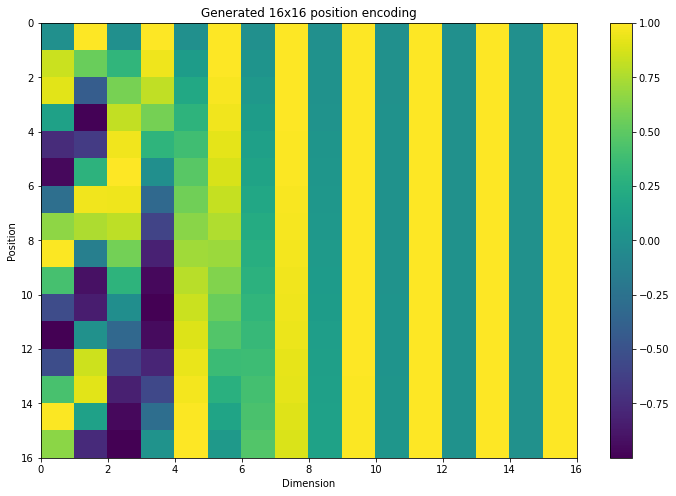

In [711]:
plt.figure(figsize=(12, 8))
plt.title('Generated 16x16 position encoding')
plt.pcolormesh(pos_enc_res[0], cmap='viridis')
plt.xlabel('Dimension')
plt.xlim((0, dims))
plt.ylim((tokens, 0))
plt.ylabel('Position')
plt.colorbar()
plt.show()

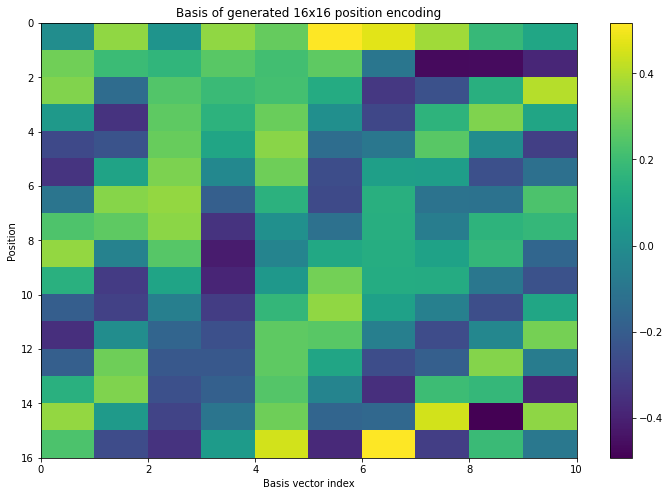

In [715]:
plt.figure(figsize=(12, 8))
plt.title('Basis of generated 16x16 position encoding')
plt.pcolormesh(basis2, cmap='viridis')
plt.xlabel('Basis vector index')
plt.xlim((0, basis2.shape[-1]))
plt.ylim((basis2.shape[-2], 0))
plt.ylabel('Position')
plt.colorbar()
plt.show()

As shown above, the plot of the initial positional encoding matrix has around 8-9 similar vectors while the second one with the bases plotted have unique ones.